### Validating Areal Interpolation

##### Outlier Neighborhood Analysis

_Note: This is a notebook previously used to inspect some of the neighborhoods that were producing outlier results via areal interpolation. This problem was resolved (we determined it was due to lake area being included in geographies) but we are leaving this notebook in the repository for documentation purposes._

Look at `spatial_operations_validation.ipynb` for a broader overview of areal interpolation results. Here, we are going to look at two of the outlier neighborhoods to see if we can get a better sense of what is going on.

Specifically, we are going to look at Edgewater and South Shore. Our areal interpolation methods differed significantly from our validation data for both; the tract-to-neighborhood crosswalk method differed significantly from validation data for South Shore but not at all for Edgewater.

In [1]:
import os
import sys
sys.path[0] = os.path.join(os.path.abspath(''),'..')  # make sure we can import from our package

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from data_pipeline.fetch_census_data import acs5_aggregate 
from data_pipeline import spatial_operations as so
from data_pipeline import interactive_mapping as im
import numpy as np
import pandas as pd
import geopandas as gpd
from IPython.display import display

In [3]:
outputs = pd.read_csv('validation_data').set_index('community_area')

In [4]:
outputs.loc['EDGEWATER']

Unnamed: 0                       21.000000
known population              57649.000010
areal-weighted sum            57639.157977
areal-weighted sum error         -9.842033
areal-weighted mean           57639.158107
areal-weighted mean error        -9.841903
pop-weighted mean            115344.242070
pop-weighted mean error       57695.242060
crosswalk                     57649.000000
crosswalk error                  -0.000010
Name: EDGEWATER, dtype: float64

In [5]:
outputs.loc['SOUTH SHORE']

Unnamed: 0                      64.000000
known population             52454.000010
areal-weighted sum           50565.720663
areal-weighted sum error     -1888.279347
areal-weighted mean          50565.720989
areal-weighted mean error    -1888.279021
pop-weighted mean            56288.843817
pop-weighted mean error       3834.843807
crosswalk                    50265.000000
crosswalk error              -2189.000010
Name: SOUTH SHORE, dtype: float64

First, we will compare maps of these neighborhoods with tract maps.

In [6]:
neighborhoods = pd.DataFrame(columns=['community_area'])
neighborhoods['community_area'] = outputs.index
neighborhoods = so.geographize(neighborhoods,'community_area').set_index('community_area')


In [7]:
edgewater = neighborhoods.loc['EDGEWATER']
edgewater_area = pd.DataFrame(columns=edgewater.index)
edgewater_area.loc[0] = edgewater.values
edgewater_area['community_area'] = 'EDGEWATER'
south_shore = neighborhoods.loc['SOUTH SHORE']
south_shore_area = pd.DataFrame(columns=south_shore.index)
south_shore_area.loc[0] = south_shore.values
south_shore_area['community_area'] = 'SOUTH SHORE'


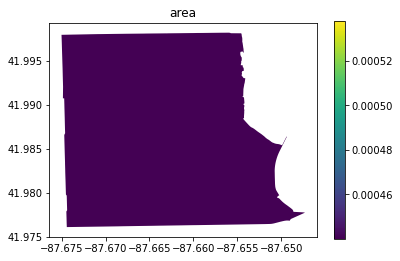

In [8]:
so.simple_map(gpd.GeoDataFrame(edgewater_area),'area',target_geography = 'community_area')

In [9]:
edgewater_map = im.InteractiveMap(gpd.GeoDataFrame(edgewater_area),target_geography='community_area')
edgewater_map.map

Map(center=[41.85, -87.6], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [10]:
# importing Census tracts mapped to community area number 
# renaming columns

tracts = pd.read_csv("../data/tracts_comm_areas.csv",
                        index_col=0,
                        parse_dates=[0]).rename(columns={
                        "COMMAREA": "comm_num",          
                        "TRACTCE10": "tract"})

# importing community area numbers and names
# renaming columns

comm_area = pd.read_csv("../data/comm_areas.csv",
                        index_col=0,
                        parse_dates=[0]).rename(columns={
                        "AREA_NUMBE": "comm_num"})

# merging both dataframes above to map tract wirh community area name

tract_area= comm_area.merge(tracts, on='comm_num')

# selecting columns we need and renaming them

tract_area=tract_area[['comm_num', 'tract']]

# 801 rows x 3 columns
# final dataframe

tract_area.head()

,comm_num,tract
0,35,842000
1,35,351500
2,35,839500
3,35,839200
4,35,839600


In [11]:
neighborhoods = neighborhoods.rename(columns={'area_numbe':'comm_num'}).reset_index()
neighborhoods['comm_num'] = neighborhoods['comm_num'].astype(np.int64)
crosswalk = tract_area.merge(neighborhoods,on='comm_num')
crosswalk.head()

,comm_num,tract,community_area,area,area_num_1,comarea,comarea_id,perimeter,shape_area,shape_len,geometry
0,35,842000,DOUGLAS,0.000463,35,0.0,0.0,0.0,4.600462e+07,31027.05451,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,35,351500,DOUGLAS,0.000463,35,0.0,0.0,0.0,4.600462e+07,31027.05451,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
2,35,839500,DOUGLAS,0.000463,35,0.0,0.0,0.0,4.600462e+07,31027.05451,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
3,35,839200,DOUGLAS,0.000463,35,0.0,0.0,0.0,4.600462e+07,31027.05451,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
4,35,839600,DOUGLAS,0.000463,35,0.0,0.0,0.0,4.600462e+07,31027.05451,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."


In [12]:
crosswalk.groupby('community_area').get_group('EDGEWATER').tract

775    30601
776    30604
777    30103
778    30102
779    30706
780    30702
781    30603
782    30701
783    30703
784    30104
785    30101
786    30200
787    30300
788    30400
789    30500
790    30800
791    30900
Name: tract, dtype: int64

This does exactly match the visually-found census tracts for the area. None of the census tracts seem to overlap any other neighborhood areas.